# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
CELL_CHANGES = ["localization", "morphology"]

%matplotlib inline

In [2]:
BIO_REP_BATCHES = ["2024_12_09_Batch_11_widefield", "2024_12_09_Batch_12_widefield"]
COMBINED_BIO_REP_DIR = "2024_12_Batch_11-12_widefield"

OUTPUT_DIR = f"../../outputs/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Metadata

In [3]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import operator

def plot_platemap(
    df,
    plate_name,
    well_pos_col="well_position",
    # this is the column to color by (categorical or continuous)
    value_col="node_type",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele",),
    value_type="categorical",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    categorical_colors=None     # dict for categorical → color
):
    # 1) build empty 16×24 grid
    rows = list("ABCDEFGHIJKLMNOP")
    cols = [f"{i:02d}" for i in range(1,25)]
    plate_grid = (
        pl.DataFrame({c: [""]*16 for c in cols})
          .with_row_index("row_index")
          .unpivot(index="row_index", on=cols, variable_name="col_label", value_name="_")
          .with_columns(
              pl.col("row_index").map_elements(lambda i: rows[i], return_dtype=pl.Utf8).alias("row_label")
          )
    )

    # 2) extract row/col from your df’s well_position
    df2 = df.with_columns([
        pl.col(well_pos_col).str.head(1).alias("row_label"),
        pl.col(well_pos_col).str.slice(1).alias("col_label")
    ])

    # 3) join
    plate = plate_grid.join(df2, on=["row_label","col_label"], how="left")

    # 4) pivot out two matrices:
    #    A) data matrix for coloring
    #    B) text matrix for annotation
    # first build annotation text by concatenating label_cols
    plate = plate.with_columns(
        reduce(
            lambda acc, c: acc + "\n" + \
            pl.col(c).round(2).cast(pl.Utf8).fill_null(""),
            label_cols[1:],
            pl.col(label_cols[0]).fill_null("").str.replace_all("_", "\n")
        ).alias("_annot")
    )

    display(plate)

    # pivot color‐matrix
    data_matrix = plate.pivot(
        index="row_label", on="col_label", values=value_col
    )

    # pivot annotation‐matrix
    annot_matrix = plate.pivot(
        index="row_label", on="col_label", values="_annot"
    ).fill_null("")

    # convert to numpy
    # drop the implicit “row_label” column in position 0
    data = data_matrix[:,1:].to_numpy()
    ann = annot_matrix[:,1:].to_numpy()

    # 5) choose coloring
    if value_type == "categorical":
        if categorical_colors is None:
            raise ValueError("Must supply categorical_colors when value_type='categorical'")
        # map each category in data to its color
        # build vectorized map
        cmap_array = np.vectorize(lambda x: categorical_colors.get(x, "white"))(data)
        # For seaborn we draw a dummy zero‐matrix
        plot_data = np.zeros_like(data, dtype=float)
        cmap = None
    else:
        # continuous: data is numeric
        plot_data = data.astype(float)
        cmap = continuous_cmap
        cmap_array = None

    # 6) plot
    plt.figure(figsize=(35,14))
    ax = sns.heatmap(
        plot_data,
        annot=ann if value_type=="categorical" else None,
        fmt="",
        cmap=cmap,
        cbar=(value_type=="continuous"),
        # linewidths=0,
        # linecolor="white",
        square=True,
        annot_kws={"size":9, "color": "black"}
    )

    # if categorical: overlay colored rectangles
    if value_type=="categorical":
        for i in range(cmap_array.shape[0]):
            for j in range(cmap_array.shape[1]):
                ax.add_patch(plt.Rectangle(
                    (j, i), 1, 1,
                    color=cmap_array[i,j],
                    # ec="black"
                ))
    else:
        # create combined annotation: value + other labels
        # you could easily extend to show gene_allele too by rebuilding ann
        for i in range(ann.shape[0]):
            for j in range(ann.shape[1]):
                txt = ann[i,j]
                # if you want gene_allele too: append "\n"+ann[i,j]
                ax.text(
                    j+0.5, i+0.5, txt,
                    ha="center", va="center", fontsize=9, color="red"
                )

    # 7) finalize axes
    ax.set_title(f"384-Well Plate: {plate_name}")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.set_xticks(np.arange(len(cols))+0.5)
    ax.set_xticklabels(cols, rotation=0)
    ax.set_yticks(np.arange(len(rows))+0.5)
    ax.set_yticklabels(rows, rotation=0)
    plt.tight_layout()
    plt.show()

    return plate

row_index,col_label,_,row_label,plate_map_name,well_position,symbol,gene_allele,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,technical_replicate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,gene_symbol,symbol_original,_annot
u32,str,str,str,str,str,str,str,str,str,f64,str,str,i64,str,str,str,str,f64,f64,str,str,f64,i64,i64,i64,i64,str,str,str,str,i64,str,i64,i64,i64,i64,i64,i64,str,str,str,str
0,"""01""","""""","""A""","""B11A1R1_P1""","""A01""","""MLH1""","""MLH1""","""Tube""",null,null,"""1%_rescreen_P01_R1""","""A01""",1,"""A01""","""B11A1R1""","""B12A1R2""","""disease_wt""",2713.0,null,null,null,1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,1,1,1,"""A""","""MLH1""","""MLH1""","""MLH1"""
1,"""01""","""""","""B""","""B11A1R1_P1""","""B01""","""MLH1""","""MLH1""","""Tube""",null,null,"""1%_rescreen_P01_R1""","""A01""",1,"""B01""","""B11A1R1""","""B12A1R2""","""disease_wt""",2713.0,null,null,null,1.0,1,3,11,12,null,null,null,null,527,null,1,3,1,1,2,1,"""B""","""MLH1""","""MLH1""","""MLH1"""
2,"""01""","""""","""C""","""B11A1R1_P1""","""C01""","""MLH1""","""MLH1_Ala29Gly""","""VUSmut_GDEh03""","""H11""",88.0,"""1%_rescreen_P01_R1""","""B01""",2,"""C01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,451.0,"""86C>G""","""Ala29Gly""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,2,3,1,"""C""","""MLH1""","""MLH1""","""MLH1 Ala29Gly"""
3,"""01""","""""","""D""","""B11A1R1_P1""","""D01""","""MLH1""","""MLH1_Ala29Gly""","""VUSmut_GDEh03""","""H11""",88.0,"""1%_rescreen_P01_R1""","""B01""",2,"""D01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,451.0,"""86C>G""","""Ala29Gly""",1.0,1,3,11,12,null,null,null,null,527,null,1,3,1,2,4,1,"""D""","""MLH1""","""MLH1""","""MLH1 Ala29Gly"""
4,"""01""","""""","""E""","""B11A1R1_P1""","""E01""","""MLH1""","""MLH1_Asn38His""","""VUSmut_GDEh03""","""D12""",92.0,"""1%_rescreen_P01_R1""","""C01""",3,"""E01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,467.0,"""112A>C""","""Asn38His""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,3,5,1,"""E""","""MLH1""","""MLH1""","""MLH1 Asn38His"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11,"""24""","""""","""L""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,""""""
12,"""24""","""""","""M""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,""""""
13,"""24""","""""","""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,""""""


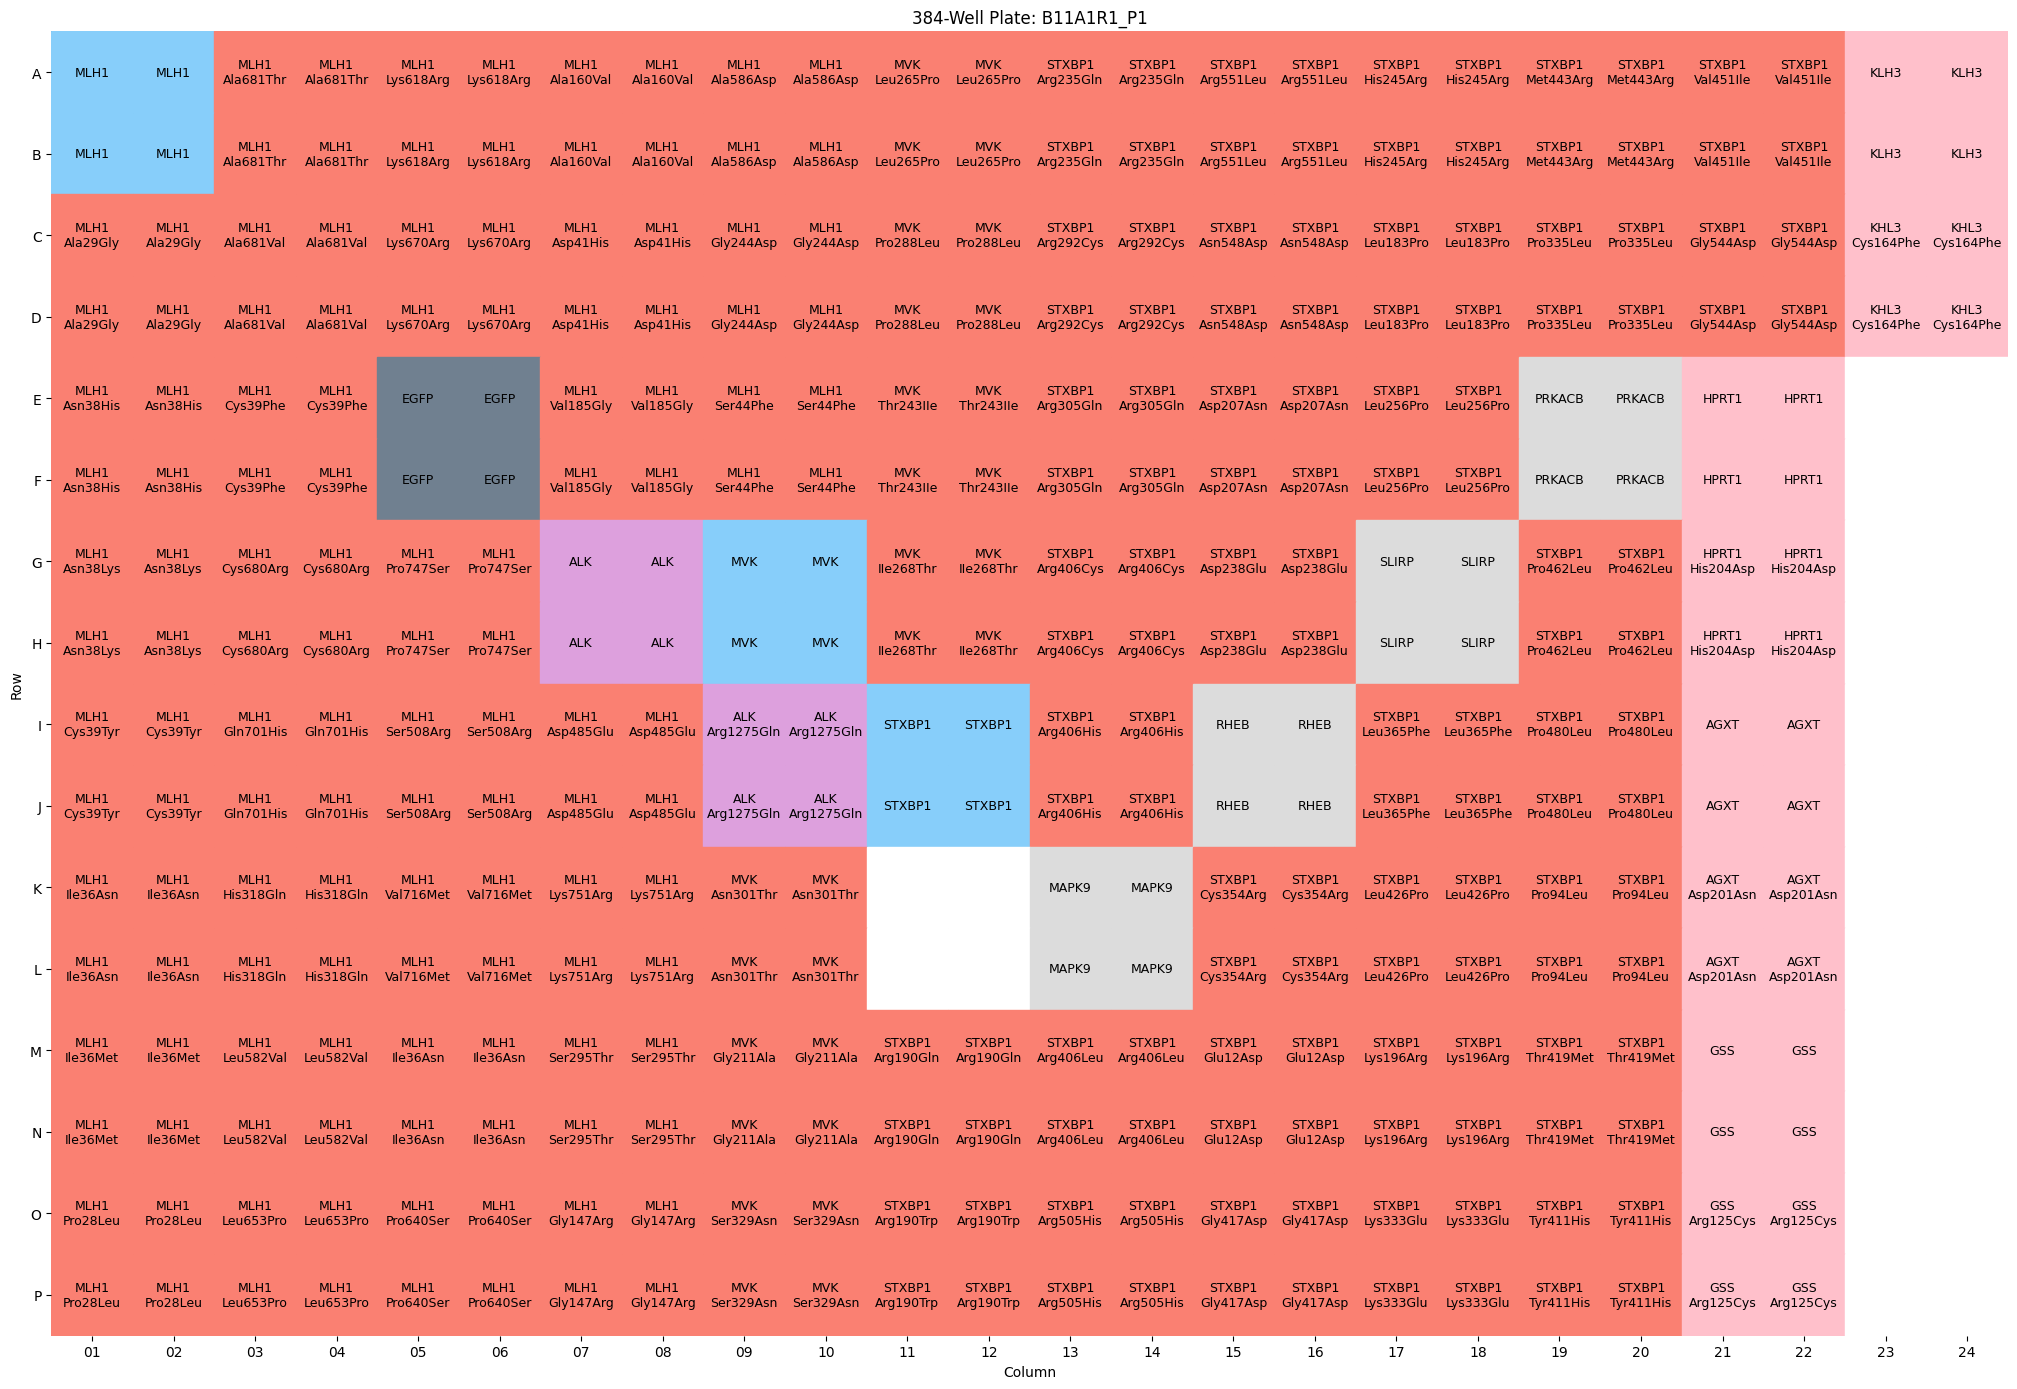

In [4]:
platemap_dir = f"../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{BIO_REP_BATCHES[0]}/platemap"

color_map = {
    'TC': 'slategrey', # Grey for controls
    'NC': 'gainsboro', 
    'PC': 'plum',
    'cPC': 'pink',
    'cNC': 'lightgrey',
    'allele': 'salmon',  # Tomato for disease
    'disease_wt': 'lightskyblue',  # Skyblue for reference
    '': 'white'  # White for missing wells
}

for platemap in os.listdir(platemap_dir):
    platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
    plate_grid = plot_platemap(
        platemap_df, 
        plate_name=platemap.split('.')[0],
        well_pos_col="well_position",
        value_col="node_type",
        label_cols=("gene_allele",),
        value_type="categorical",
        categorical_colors=color_map
    )

In [5]:
platemap_df.filter(pl.col("node_type")=="allele").group_by(by="symbol").len().sort(by="len", descending=True)
platemap_df

plate_map_name,well_position,symbol,gene_allele,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,technical_replicate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,gene_symbol,symbol_original
str,str,str,str,str,str,f64,str,str,i64,str,str,str,str,f64,f64,str,str,f64,i64,i64,i64,i64,str,str,str,str,i64,str,i64,i64,i64,i64,i64,i64,str,str,str
"""B11A1R1_P1""","""A01""","""MLH1""","""MLH1""","""Tube""",null,null,"""1%_rescreen_P01_R1""","""A01""",1,"""A01""","""B11A1R1""","""B12A1R2""","""disease_wt""",2713.0,null,null,null,1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,1,1,1,"""A""","""MLH1""","""MLH1"""
"""B11A1R1_P1""","""C01""","""MLH1""","""MLH1_Ala29Gly""","""VUSmut_GDEh03""","""H11""",88.0,"""1%_rescreen_P01_R1""","""B01""",2,"""C01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,451.0,"""86C>G""","""Ala29Gly""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,2,3,1,"""C""","""MLH1""","""MLH1"""
"""B11A1R1_P1""","""E01""","""MLH1""","""MLH1_Asn38His""","""VUSmut_GDEh03""","""D12""",92.0,"""1%_rescreen_P01_R1""","""C01""",3,"""E01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,467.0,"""112A>C""","""Asn38His""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,3,5,1,"""E""","""MLH1""","""MLH1"""
"""B11A1R1_P1""","""G01""","""MLH1""","""MLH1_Asn38Lys""","""VUSmut_GDEh03""","""E12""",93.0,"""1%_rescreen_P01_R1""","""D01""",4,"""G01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,470.0,"""114C>G""","""Asn38Lys""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,4,7,1,"""G""","""MLH1""","""MLH1"""
"""B11A1R1_P1""","""I01""","""MLH1""","""MLH1_Cys39Tyr""","""VUSmut_GDEh03""","""F12""",94.0,"""1%_rescreen_P01_R1""","""E01""",5,"""I01""","""B11A1R1""","""B12A1R2""","""allele""",2713.0,472.0,"""116G>A""","""Cys39Tyr""",1.0,1,1,11,12,null,null,null,null,527,null,1,1,1,5,9,1,"""I""","""MLH1""","""MLH1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B11A1R1_P1""","""L22""","""AGXT""","""AGXT_Asp201Asn""","""594 Controls """,null,null,"""1%_rescreen_P01_R1""","""F11""",86,"""L22""","""B11A1R1""","""B12A1R2""","""cPC""",null,null,null,null,null,1,4,11,12,null,null,null,null,594,null,1,4,11,6,12,22,"""L""","""AGXT""","""AGXT"""
"""B11A1R1_P1""","""N22""","""GSS""","""GSS""","""594 Controls """,null,null,"""1%_rescreen_P01_R1""","""G11""",87,"""N22""","""B11A1R1""","""B12A1R2""","""cPC""",null,null,null,null,null,1,4,11,12,null,null,null,null,594,null,1,4,11,7,14,22,"""N""","""GSS""","""GSS"""
"""B11A1R1_P1""","""P22""","""GSS""","""GSS_Arg125Cys""","""594 Controls """,null,null,"""1%_rescreen_P01_R1""","""H11""",88,"""P22""","""B11A1R1""","""B12A1R2""","""cPC""",null,null,null,null,null,1,4,11,12,null,null,null,null,594,null,1,4,11,8,16,22,"""P""","""GSS""","""GSS"""


## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier:

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [6]:
metrics_files = [
    f"../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv" \
    for batch_id in BIO_REP_BATCHES
]
metric_df_dict = {}

for metric_file in metrics_files:
    metrics_df = pl.read_csv(metric_file)

    batch_id = [subdir for subdir in metric_file.split("/") if "Batch" in subdir][0]
    batch_id = f"B{batch_id.split('Batch_')[-1]}"

    # print(metrics_df)
    # metrics_df = metrics_df.filter((~pl.col("Plate").str.contains("B13"))&(~pl.col("Plate").str.contains("B14")))

    metrics_df = metrics_df.with_columns(
        pl.when(pl.col("Metadata_Control"))
        .then(pl.lit("1_Ctrl"))
        .otherwise(pl.lit("2_VAR-WT"))
        .alias("Node_Type"),
        pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
        .then(pl.lit("localization"))
        .otherwise(pl.lit("morphology"))
        .alias("Classifier_type"),
        # Extract the substring that:
        #  1. Has a digit (\d) immediately before it (anchors the match at a number)
        #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
        #  3. Stops right before the literal 'T'
        pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
        pl.col("Full_Classifier_ID").str.split("_").list.tail(2).list.join("_").alias("Batch")
    )
    display(metrics_df)
    # Filter based on class imbalance
    metrics_ctrl = (
        metrics_df.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )
        .select(["Classifier_type", "Batch", "AUROC"])
        .group_by(["Classifier_type", "Batch"])
        .agg([
            pl.col("AUROC").quantile(0.99).alias("AUROC_thresh"),
            pl.col("AUROC").mean().alias("AUROC_mean"),
            pl.col("AUROC").std().alias("AUROC_std")
        ])
    )
    # print(metrics_ctrl)

    metric_df_dict[f"{batch_id}_met"] = metrics_df

    # Merge with metrics_df and decide whether it passed the threshold
    metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
    # print(metrics_df_thres.head())

    metrics_df_thres = metrics_df_thres.with_columns(
        ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
    )

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("Total number of unique classifiers:", classifier_count.shape[0])
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            & (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("After filtering out classifiers with training imbalance > 3:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    classifier_count = classifier_count.filter(
        (pl.col(batch_id) >= MIN_CLASS_NUM)
    )
    print("After filtering out alleles with available number of classifiers < 2:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))

    # filter based on this
    keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
    metrics_df_thres = metrics_df_thres.filter(
        ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
    )

    # Filter by imbalance and calculate mean AUROC for each batch
    metrics_wtvar = (
        (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
            )
        )
        .select([
            "AUROC",
            "AUROC_zscore",
            "Classifier_type",
            "Batch",
            "AUROC_thresh",
            "allele_0",
            "trainsize_0",
            "testsize_0",
            "trainsize_1",
            "testsize_1",
            "Allele_set",
            "Training_imbalance",
        ])
        .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
        .agg([
            pl.all()
            .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
            .mean()
            .name.suffix("_mean")
        ])
    )

    metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
    metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

    metrics_wtvar.write_csv(
        os.path.join("/".join(metric_file.split("/")[:-1]),
                     f"metrics_summary.csv"),
    )

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str
0.530941,0.489258,0.522992,0.507798,0.470501,0.545103,0.507802,"""2024-12-09_B11A1R1_widefield_J…","""2024-12-09_B11A1R1_widefield_J…","""2024-12-09_B11A1R1_widefield""",821,776,"""J16""","""RHEB""",626,678,"""I15""","""RHEB""",true,0.432619,0.4663,1.311502,1.144543,"""1_Ctrl""","""localization""",null,"""B11_widefield"""
1.0,1.0,1.0,0.991152,1.0,0.977578,0.988789,"""2024-12-09_B11A1R1_widefield_M…","""2024-12-09_B11A1R1_widefield_M…","""2024-12-09_B11A1R1_widefield""",2474,669,"""M09""","""MVK_Gly211Ala""",3971,1172,"""G09""","""MVK""",false,0.616137,0.636611,1.605093,1.751868,"""2_VAR-WT""","""morphology""",null,"""B11_widefield"""
0.973305,0.97087,0.971552,0.92378,0.936214,0.911647,0.92393,"""2024-12-09_B11A1R1_widefield_D…","""2024-12-09_B11A1R1_widefield_D…","""2024-12-09_B11A1R1_widefield""",1416,498,"""D18""","""STXBP1_Leu183Pro""",1371,486,"""J12""","""STXBP1""",false,0.491927,0.493902,1.032823,1.024691,"""2_VAR-WT""","""localization""",null,"""B11_widefield"""
0.988348,0.989041,0.988638,0.926616,0.982079,0.869888,0.925984,"""2024-12-09_B11A1R1_widefield_H…","""2024-12-09_B11A1R1_widefield_H…","""2024-12-09_B11A1R1_widefield""",1903,538,"""H02""","""MLH1_Asn38Lys""",1551,558,"""A01""","""MLH1""",false,0.449045,0.509124,1.22695,1.037175,"""2_VAR-WT""","""morphology""",null,"""B11_widefield"""
0.548832,0.489802,0.542785,0.516948,0.654048,0.409864,0.531956,"""2024-12-09_B11A1R1_widefield_L…","""2024-12-09_B11A1R1_widefield_L…","""2024-12-09_B11A1R1_widefield""",1411,1176,"""L14""","""MAPK9""",1262,951,"""K14""","""MAPK9""",true,0.472129,0.447109,1.118067,1.236593,"""1_Ctrl""","""localization""",null,"""B11_widefield"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.997337,0.998244,0.997235,0.957642,0.998208,0.90113,0.949669,"""2024-12-09_B11A1R1_widefield_J…","""2024-12-09_B11A1R1_widefield_J…","""2024-12-09_B11A1R1_widefield""",1066,354,"""J07""","""MLH1_Asp485Glu""",1551,558,"""A01""","""MLH1""",false,0.592663,0.611842,1.454972,1.576271,"""2_VAR-WT""","""localization""",null,"""B11_widefield"""
0.988824,0.988462,0.98951,0.93727,0.921212,0.952294,0.936753,"""2024-12-09_B11A1R1_widefield_A…","""2024-12-09_B11A1R1_widefield_A…","""2024-12-09_B11A1R1_widefield""",1955,545,"""A06""","""MLH1_Lys618Arg""",1614,495,"""B01""","""MLH1""",false,0.452228,0.475962,1.211276,1.10101,"""2_VAR-WT""","""localization""",null,"""B11_widefield"""
0.945102,0.92159,0.950076,0.864965,0.86558,0.874214,0.869897,"""2024-12-09_B11A1R1_widefield_P…","""2024-12-09_B11A1R1_widefield_P…","""2024-12-09_B11A1R1_widefield""",1867,795,"""P11""","""STXBP1_Arg190Trp""",1366,491,"""J11""","""STXBP1""",false,0.422518,0.381804,1.366764,1.619145,"""2_VAR-WT""","""localization""",null,"""B11_widefield"""


Total number of unique classifiers: 71
Total number of unique variant alleles: 71
Total number of unique WT genes: 6
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (71, 4)
Total number of unique variant alleles: 71
Total number of unique WT genes: 6
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (71, 4)
Total number of unique variant alleles: 71
Total number of unique WT genes: 6


AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str
0.831935,0.829205,0.836317,0.741407,0.637555,0.847856,0.742705,"""2024-12-09_B12A1R2_widefield_N…","""2024-12-09_B12A1R2_widefield_N…","""2024-12-09_B12A1R2_widefield""",2413,723,"""N02""","""MLH1_Ile36Met""",1784,687,"""B02""","""MLH1""",false,0.425066,0.487234,1.352578,1.052402,"""2_VAR-WT""","""localization""",null,"""B12_widefield"""
1.0,1.0,1.0,0.99829,1.0,0.99646,0.99823,"""2024-12-09_B12A1R2_widefield_O…","""2024-12-09_B12A1R2_widefield_O…","""2024-12-09_B12A1R2_widefield""",1617,565,"""O07""","""MLH1_Gly147Arg""",1865,606,"""B01""","""MLH1""",false,0.535612,0.517506,1.15337,1.072566,"""2_VAR-WT""","""morphology""",null,"""B12_widefield"""
0.999476,0.998894,0.999514,0.992702,0.988739,0.996044,0.992391,"""2024-12-09_B12A1R2_widefield_J…","""2024-12-09_B12A1R2_widefield_J…","""2024-12-09_B12A1R2_widefield""",2587,1011,"""J03""","""MLH1_Gln701His""",2027,444,"""A01""","""MLH1""",false,0.439315,0.305155,1.27627,2.277027,"""2_VAR-WT""","""morphology""",null,"""B12_widefield"""
0.997239,0.997417,0.997588,0.94476,0.887918,0.998641,0.94328,"""2024-12-09_B12A1R2_widefield_D…","""2024-12-09_B12A1R2_widefield_D…","""2024-12-09_B12A1R2_widefield""",2518,736,"""D04""","""MLH1_Ala681Val""",1784,687,"""B02""","""MLH1""",false,0.414691,0.482783,1.411435,1.071325,"""2_VAR-WT""","""morphology""",null,"""B12_widefield"""
0.893357,0.753127,0.875175,0.802608,0.739766,0.871501,0.805634,"""2024-12-09_B12A1R2_widefield_K…","""2024-12-09_B12A1R2_widefield_K…","""2024-12-09_B12A1R2_widefield""",2421,786,"""K20""","""STXBP1_Pro94Leu""",1320,342,"""I12""","""STXBP1""",false,0.352847,0.303191,1.834091,2.298246,"""2_VAR-WT""","""localization""",null,"""B12_widefield"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.990366,0.986041,0.991578,0.936527,0.868421,0.985965,0.927193,"""2024-12-09_B12A1R2_widefield_M…","""2024-12-09_B12A1R2_widefield_M…","""2024-12-09_B12A1R2_widefield""",1834,570,"""M20""","""STXBP1_Thr419Met""",1320,342,"""I12""","""STXBP1""",false,0.418516,0.375,1.389394,1.666667,"""2_VAR-WT""","""morphology""",null,"""B12_widefield"""
0.992445,0.99514,0.99237,0.923404,0.995495,0.826241,0.910868,"""2024-12-09_B12A1R2_widefield_J…","""2024-12-09_B12A1R2_widefield_J…","""2024-12-09_B12A1R2_widefield""",934,282,"""J07""","""MLH1_Asp485Glu""",2027,444,"""A01""","""MLH1""",false,0.684566,0.61157,2.170236,1.574468,"""2_VAR-WT""","""localization""",null,"""B12_widefield"""
0.929471,0.941961,0.940054,0.863617,0.871622,0.855478,0.86355,"""2024-12-09_B12A1R2_widefield_D…","""2024-12-09_B12A1R2_widefield_D…","""2024-12-09_B12A1R2_widefield""",1025,429,"""D02""","""MLH1_Ala29Gly""",2027,444,"""A01""","""MLH1""",false,0.664155,0.508591,1.977561,1.034965,"""2_VAR-WT""","""morphology""",null,"""B12_widefield"""


Total number of unique classifiers: 71
Total number of unique variant alleles: 71
Total number of unique WT genes: 6
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (69, 4)
Total number of unique variant alleles: 69
Total number of unique WT genes: 6
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (69, 4)
Total number of unique variant alleles: 69
Total number of unique WT genes: 6


## 3. Plotting Metrics

In [7]:
def plot_metric_dist(df, value, batch, col="Node_Type", hue="Node_Type"):
    g = sns.displot(
        data=df, 
        x=value, col=col, kde=True, hue=hue, 
        facet_kws={'sharey': False, 'col_order': sorted(df[col].unique())},
        palette="Set2", hue_order=sorted(df[hue].unique()),
        legend=False, height=4, aspect=1.1
    )
    g.fig.suptitle(f"Batch {batch} {value}", fontsize=12, y=1.)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.9)
    g.savefig(
        os.path.join(OUTPUT_DIR, f"B{batch}_{value}_dist.png"),
        dpi=300,
        bbox_inches="tight"
    )

AUROC 99th percentile threshold for localization in 2024_12_09_Batch_11_widefield: 0.702
AUROC 99th percentile threshold for morphology in 2024_12_09_Batch_11_widefield: 1.000
AUROC 99th percentile threshold for localization in 2024_12_09_Batch_12_widefield: 0.644
AUROC 99th percentile threshold for morphology in 2024_12_09_Batch_12_widefield: 0.999


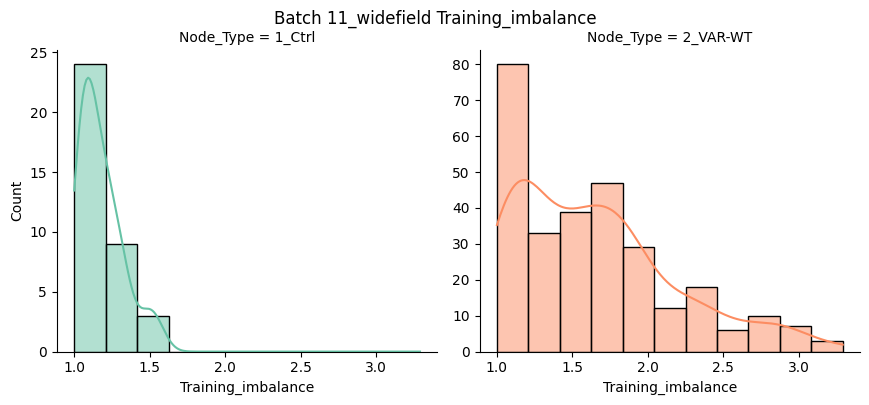

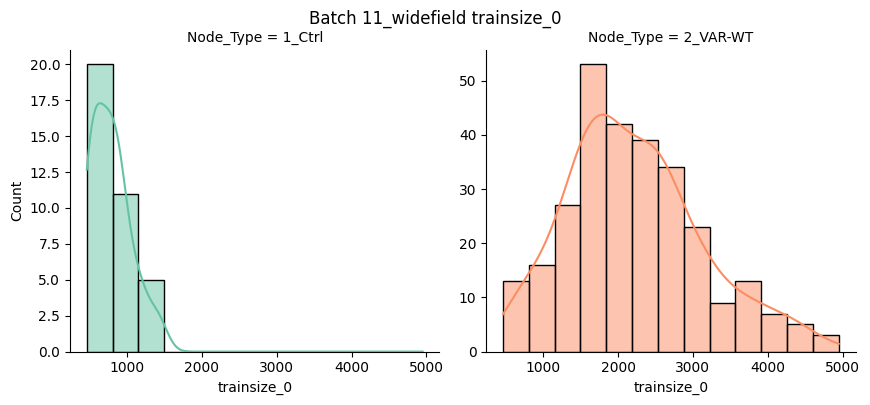

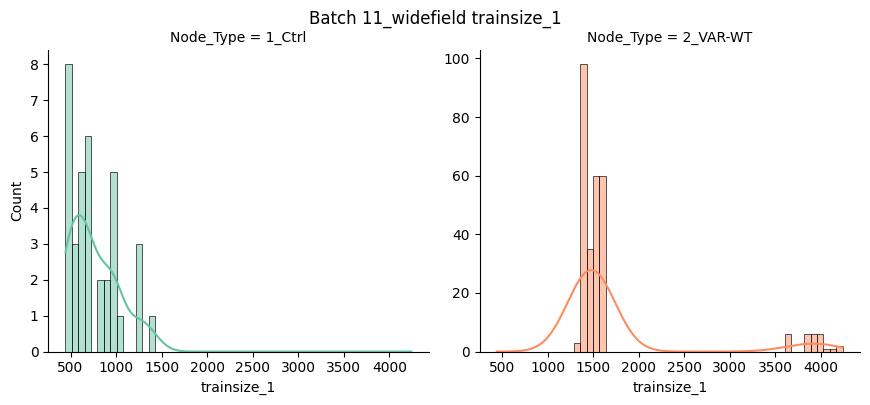

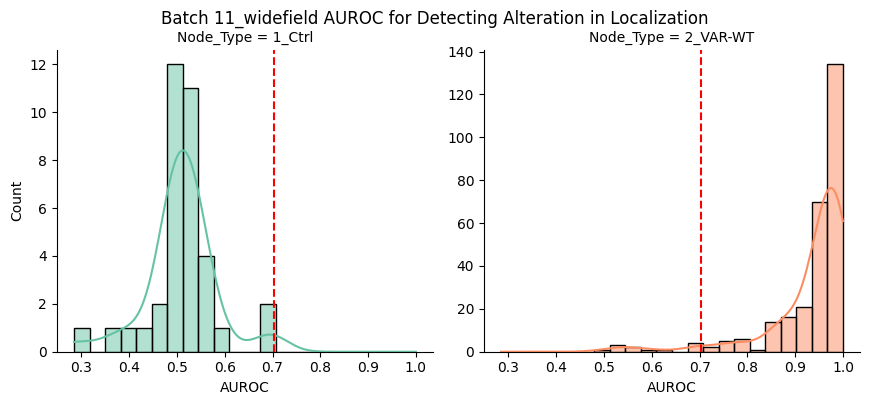

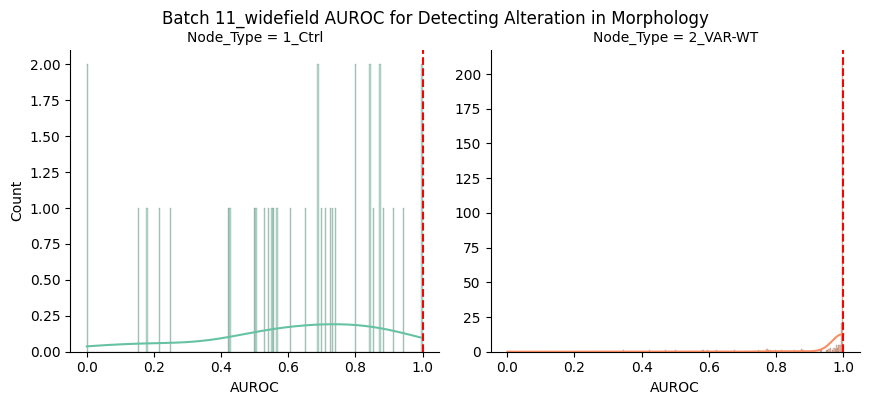

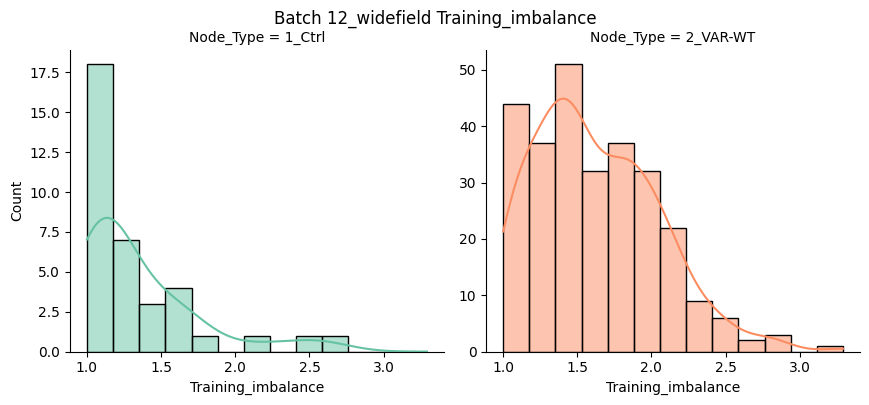

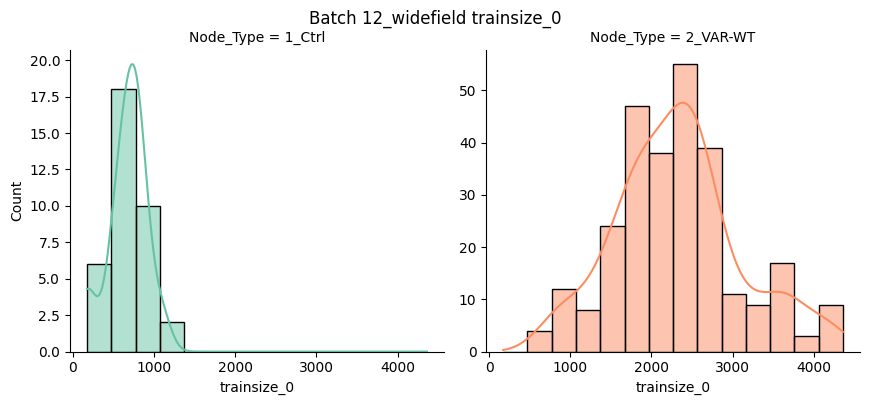

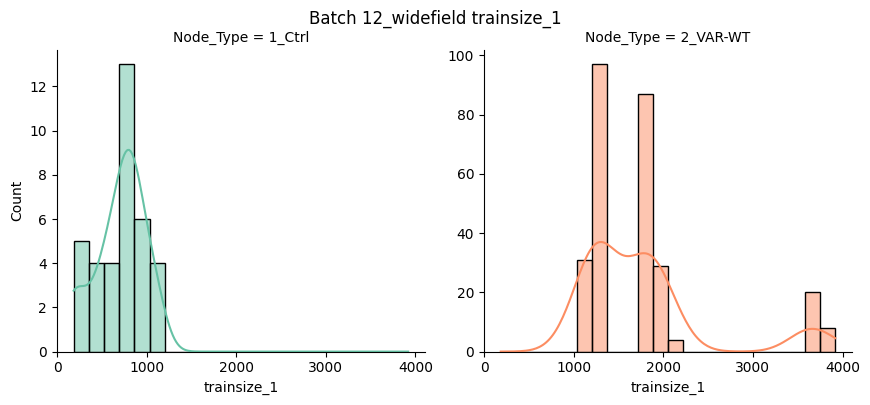

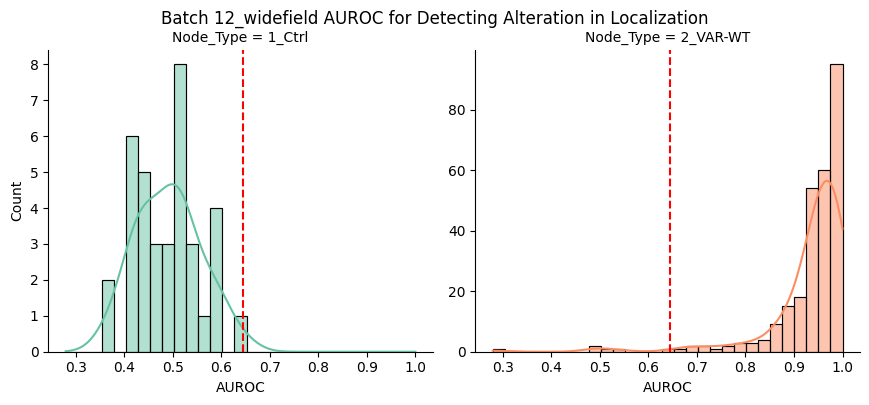

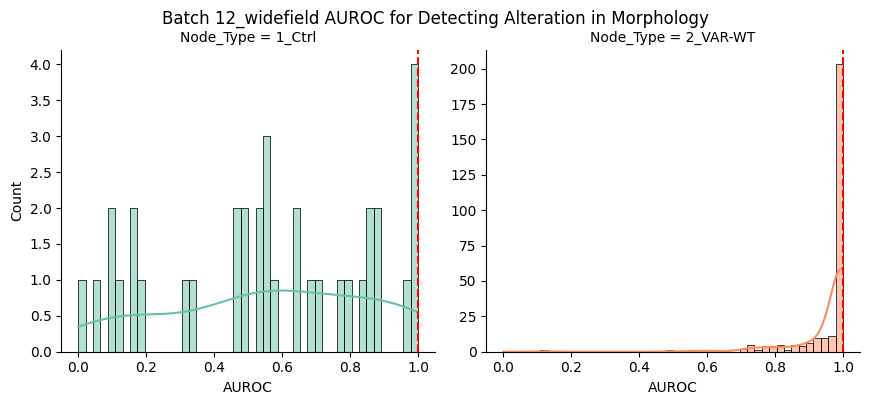

In [8]:
for batch_id in BIO_REP_BATCHES:
    batch_num = batch_id.split("_")[-2] + "_widefield"
    for change in CELL_CHANGES:
        ## Only need to plot for one change, since the other is duplicative
        if change == "localization":
            df_local = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change)
            plot_metric_dist(df_local, value="Training_imbalance", batch=batch_num, col="Node_Type")
            plot_metric_dist(df_local, value="trainsize_0", batch=batch_num, col="Node_Type")
            plot_metric_dist(df_local, value="trainsize_1", batch=batch_num, col="Node_Type")

        perc_99 = metric_df_dict[f"B{batch_num}_met_thres"].filter(pl.col("Classifier_type") == change).select("AUROC_thresh").mean().to_numpy()[0][0]
        print(f"AUROC 99th percentile threshold for {change} in {batch_id}: {perc_99:.3f}")

        # Plot with vertical lines
        g = sns.displot(
            data=metric_df_dict[f"B{batch_num}_met_thres"].filter((pl.col("Classifier_type") == change)&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), x="AUROC", col="Node_Type", kde=True,
            facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
            hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
            legend=False, height=4, aspect=1.1
        )
        ## Add vertical lines and labels
        for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
            ax.axvline(perc_99, color='red', linestyle='--')
            # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
        # plt.show()

        g.fig.suptitle(f"Batch {batch_num} AUROC for Detecting Alteration in {change.capitalize()}", fontsize=12, y=1.)
        g.fig.subplots_adjust(top=0.9)
        g.savefig(
            os.path.join(OUTPUT_DIR, f"B{batch_num}_{change}_dist.png"),
            dpi=300,
            bbox_inches="tight"
        )

In [9]:
metrics_files = [
    f"../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv" \
    for batch_id in BIO_REP_BATCHES
]

metric_sum_df_dict = {}
for metric_file in metrics_files:
    metric_sum_df = pl.read_csv(metric_file)

    # Assuming you have a Polars DataFrame named df and you want to rank the values in the 'column_name' column
    metric_sum_df = metric_sum_df.with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    )

    # for classifier in ["morphology", "localization"]:
    #     sns.displot(data=metric_sum_df.filter(pl.col("Classifier_type")==classifier), x="AUROC_mean", kde=True)
        # display(metric_sum_df.filter((pl.col("Classifier_type") == classifier)&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).head())

    metric_sum_df_dict[metric_file.split("/")[-3]] = metric_sum_df

## 3. Correlation between biological replicates

Spearman's correlation: 0.9135915235659482
Spearman's correlation: 0.5745341614906833


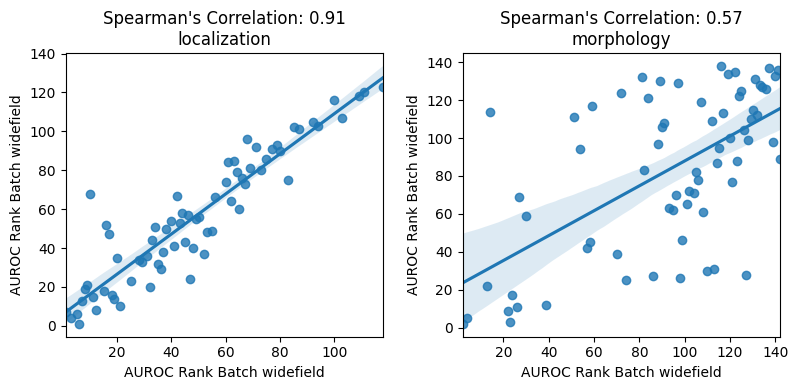

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 2, figsize=(8,4))
for classifier_type in CELL_CHANGES:
    # Select the columns "allele_0" and "AUROC_rank" from both dataframes
    set1_ranks = metric_sum_df_dict[BIO_REP_BATCHES[0]].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
    set2_ranks = metric_sum_df_dict[BIO_REP_BATCHES[1]].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
    # Join the dataframes on the "allele_0" column
    joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch14")
    # Calculate the Spearman's correlation between the ranks
    spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch14"])
    print(f"Spearman's correlation: {spearman_corr}")

    # Plot the correlation using a regression plot
    sns.regplot(x="AUROC_rank", y="AUROC_rank_batch14", data=joined_ranks.to_pandas(), ax=axes[CELL_CHANGES.index(classifier_type)])
    axes[CELL_CHANGES.index(classifier_type)].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
    axes[CELL_CHANGES.index(classifier_type)].set_xlabel(f"AUROC Rank Batch {BIO_REP_BATCHES[0].split('_')[-1]}")
    axes[CELL_CHANGES.index(classifier_type)].set_ylabel(f"AUROC Rank Batch {BIO_REP_BATCHES[1].split('_')[-1]}")

plt.tight_layout()
plt.subplots_adjust(wspace=.25)

In [11]:
# set1 = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))
# set2 = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))

## 4. Calling hits

In [12]:
from functools import reduce
import operator

metrics_sum_wtvar = pl.concat(list(metric_sum_df_dict.values()))
# metrics_sum_wtvar

In [13]:
# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
morph_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == "localization")
print(local_wtvar.shape)
print(morph_wtvar.shape)

(140, 13)
(140, 13)


In [14]:
morph_wtvar

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh,AUROC_mean,AUROC_zscore_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean,AUROC_rank
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,u32
"""morphology""","""HPRT1_His204Asp""",null,"""B11_widefield""",0.999743,0.924581,1.130634,1845.0,615.0,4152.0,1384.0,2.297405,24
"""morphology""","""MVK_Ser329Asn""",null,"""B11_widefield""",0.999743,0.995896,1.393879,2016.0,672.0,3857.25,1285.75,1.913038,90
"""morphology""","""MLH1_Ala586Asp""",null,"""B11_widefield""",0.999743,0.995755,1.393359,1537.5,512.5,1581.75,527.25,1.040696,89
"""morphology""","""STXBP1_Pro335Leu""",null,"""B11_widefield""",0.999743,0.998942,1.405121,1615.5,538.5,1392.75,464.25,1.159679,112
"""morphology""","""STXBP1_Asp207Asn""",null,"""B11_widefield""",0.999743,0.998997,1.405323,3177.75,1059.25,1392.75,464.25,2.281819,114
…,…,…,…,…,…,…,…,…,…,…,…,…
"""morphology""","""MLH1_Asn38Lys""",null,"""B12_widefield""",0.998525,0.858609,0.960179,2316.75,772.25,1853.25,617.75,1.252775,11
"""morphology""","""STXBP1_Arg406Cys""",null,"""B12_widefield""",0.998525,0.970352,1.323707,2627.25,875.75,1246.5,415.5,2.119693,71
"""morphology""","""MLH1_His318Gln""",null,"""B12_widefield""",0.998525,0.997788,1.412965,2584.5,861.5,1853.25,617.75,1.396693,111


In [18]:
for cell_change in CELL_CHANGES:
    ## Filter the change to detect
    cell_chg_wtvar = metrics_sum_wtvar.filter(pl.col("Classifier_type") == cell_change)
    ## Per each batch, get the hits
    cell_chg_wtvar = cell_chg_wtvar.with_columns(
        pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
        .then(1)
        .otherwise(0)
        .alias(f"Altered_{cell_change[:5]}")
    ).unique()
    # print(cell_chg_wtvar.filter(pl.col("allele_0")=="DES_Asp343Asn"))
    # break
    ## Per combine the hits from both batches
    change_binary = (
        cell_chg_wtvar.pivot(
            index=["allele_0"], ## , "Allele_set"
            on="Batch",
            values=f"Altered_{cell_change[:5]}",
        )
        # 1) rename each pivoted batch-column
        .rename({f"B{'_'.join(batch.split('_')[-2:])}": f"Altered_{cell_change[:5]}_batch{'_'.join(batch.split('_')[-2:])}" for batch in BIO_REP_BATCHES})
        # 2) add the “both” column by AND-reducing all of them
        .with_columns(
            reduce(
                operator.and_,
                [pl.col(f"Altered_{cell_change[:5]}_batch{'_'.join(batch.split('_')[-2:])}") == 1 for batch in BIO_REP_BATCHES]
            ).alias(f"Altered_{cell_change[:5]}_both_batches")
        )
    )
    ## Per combine the AUROC scores from both batches
    change_auroc = cell_chg_wtvar.pivot(
        index=["allele_0"],
        on="Batch",
        values="AUROC_mean",
    ).rename(
        {f"B{'_'.join(batch.split('_')[-2:])}": f"AUROC_batch{'_'.join(batch.split('_')[-2:])}" for batch in BIO_REP_BATCHES}
    ).with_columns(
        (
            reduce(
                operator.add,
                [
                    pl.col(f"AUROC_batch{'_'.join(batch.split('_')[-2:])}")
                    for batch in BIO_REP_BATCHES
                ]
            )
            / len(BIO_REP_BATCHES)
        ).alias("AUROC_Mean")
    )
    change_summary = change_binary.join(change_auroc, on="allele_0")
    display(change_summary)
    display(change_summary.filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")))
    change_summary.write_csv(f"{OUTPUT_DIR}/altered_{cell_change[:5]}_summary_auroc.csv")

allele_0,Altered_local_batch11_widefield,Altered_local_batch12_widefield,Altered_local_both_batches,AUROC_batch11_widefield,AUROC_batch12_widefield,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""STXBP1_Arg406Cys""",1,1,true,0.942364,0.956642,0.949503
"""MLH1_Ile36Met""",1,1,true,0.905299,0.830093,0.867696
"""MLH1_Cys680Arg""",1,1,true,0.970405,0.952283,0.961344
"""MLH1_Leu582Val""",1,1,true,0.968794,0.948975,0.958884
"""MLH1_Ala29Gly""",1,1,true,0.722993,0.723931,0.723462
…,…,…,…,…,…,…
"""MLH1_Gly147Arg""",1,1,true,0.993262,0.994779,0.99402
"""MLH1_Asn38His""",1,1,true,0.964276,0.945878,0.955077
"""STXBP1_His245Arg""",1,1,true,0.938117,0.935732,0.936925


allele_0,Altered_local_batch11_widefield,Altered_local_batch12_widefield,Altered_local_both_batches,AUROC_batch11_widefield,AUROC_batch12_widefield,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""STXBP1_Arg406Cys""",1,1,true,0.942364,0.956642,0.949503
"""MLH1_Ile36Met""",1,1,true,0.905299,0.830093,0.867696
"""MLH1_Cys680Arg""",1,1,true,0.970405,0.952283,0.961344
"""MLH1_Leu582Val""",1,1,true,0.968794,0.948975,0.958884
"""MLH1_Ala29Gly""",1,1,true,0.722993,0.723931,0.723462
…,…,…,…,…,…,…
"""MLH1_Gly147Arg""",1,1,true,0.993262,0.994779,0.99402
"""MLH1_Asn38His""",1,1,true,0.964276,0.945878,0.955077
"""STXBP1_His245Arg""",1,1,true,0.938117,0.935732,0.936925


allele_0,Altered_morph_batch11_widefield,Altered_morph_batch12_widefield,Altered_morph_both_batches,AUROC_batch11_widefield,AUROC_batch12_widefield,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""MVK_Ser329Asn""",0,0,false,0.995896,0.996329,0.996113
"""STXBP1_Arg505His""",1,0,false,0.999973,0.989407,0.99469
"""MLH1_Pro747Ser""",1,1,true,0.999909,0.999488,0.999699
"""STXBP1_Glu12Asp""",0,0,false,0.997835,0.965941,0.981888
"""MLH1_Asp41His""",0,1,false,0.999298,0.999871,0.999584
…,…,…,…,…,…,…
"""STXBP1_Arg190Gln""",1,0,false,1.0,0.983713,0.991856
"""MLH1_Lys670Arg""",0,1,false,0.999412,0.999646,0.999529
"""STXBP1_Met443Arg""",0,0,false,0.998272,0.978937,0.988605


allele_0,Altered_morph_batch11_widefield,Altered_morph_batch12_widefield,Altered_morph_both_batches,AUROC_batch11_widefield,AUROC_batch12_widefield,AUROC_Mean
str,i32,i32,bool,f64,f64,f64
"""MLH1_Pro747Ser""",1,1,true,0.999909,0.999488,0.999699
"""MLH1_Gly147Arg""",1,1,true,0.999876,0.999584,0.99973
"""MLH1_Asp485Glu""",1,1,true,0.999938,0.999483,0.99971
"""MVK_Gly211Ala""",1,1,true,0.999959,0.999821,0.99989
"""MLH1_Ser44Phe""",1,1,true,0.999978,0.999728,0.999853
"""MLH1_Val185Gly""",1,1,true,0.999974,0.99961,0.999792
"""MLH1_Lys751Arg""",1,1,true,0.999745,0.999414,0.999579
"""MVK_Asn301Thr""",1,1,true,0.999889,0.999517,0.999703
